# Lab 2: Deep Learning
## Universidad Santiago de Compostela

Students:
- Víctor Barreiro Domínguez
- Maximiliano Hormazábal Lagos


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow.keras

2023-02-06 13:37:41.664683: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Load dataset

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000) 

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/victorxbd/anaconda3/envs/mia2cuadri/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/victorxbd/anaconda3/envs/mia2cuadri/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wit

In [3]:
# word_index is a dictionary mapping words to integer index
word_index = imdb.get_word_index()

# Reverses it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Decodes de review. Note that the indices are offset by 3 because 0, 1, and 2 are reserved 
# indices por "padding", "start of sequence" and "unknown"
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [4]:
import numpy as np
def vectorize_sequences(sequences, dimension = 10000):
    # Creates an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        # Sets specific indices of results[i] to 1s
        results[i, sequence] = 1.
    return results

# Vectorized training data
x_train = vectorize_sequences(train_data)

# Vectorized test data
x_test = vectorize_sequences(test_data)

print(x_train[0])

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

[0. 1. 1. ... 0. 0. 0.]


# Model

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers

# we are using the name parameter to identify better model and layers
model = models.Sequential(name='imdb')

# using the input_shappe parameter Keras will create an input layer to insert before the current layer. 
model.add(layers.Dense(16, name='hidden_1', activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, name='hidden_2',activation='relu'))
model.add(layers.Dense(1, name='output',  activation='sigmoid'))

model.summary()

Model: "imdb"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 16)                160016    
_________________________________________________________________
hidden_2 (Dense)             (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


2023-02-06 13:37:50.858936: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-06 13:37:50.859851: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-06 13:37:51.295812: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-02-06 13:37:51.295905: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: victorxbd-PROX15-INTEL
2023-02-06 13:37:51.295913: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: victorxbd-PROX15-INTEL
2023-02-06 13:37:51.296582: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-02-06 13:37:51.296653: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-02-06 13:37:51.296668: I tensorflow/stream_execut

In [6]:
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [7]:
from tensorflow.keras import regularizers

regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)

## Validation set and crossvalidation

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=3)

In [9]:
# === Build the model ===
model = models.Sequential(name='imdb')
model.add(layers.Dense(16, name='hidden_1', activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, name='hidden_2',activation='relu'))
model.add(layers.Dense(1, name='output',  activation='sigmoid'))

model.summary()

# === Train the model ===

# Compile the model
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history = model.fit(x_train,
                    y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_split = 0.4,
                    callbacks=[early_stopping])



Model: "imdb"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 16)                160016    
_________________________________________________________________
hidden_2 (Dense)             (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


2023-02-06 13:37:52.912545: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-06 13:37:52.932623: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/20
30/30 [==============================] - 3s 76ms/step - loss: 0.6471 - accuracy: 0.6045 - val_loss: 0.5228 - val_accuracy: 0.7782
Epoch 2/20
30/30 [==============================] - 1s 34ms/step - loss: 0.4684 - accuracy: 0.8442 - val_loss: 0.3902 - val_accuracy: 0.8733
Epoch 3/20
30/30 [==============================] - 1s 34ms/step - loss: 0.3123 - accuracy: 0.9210 - val_loss: 0.3503 - val_accuracy: 0.8662
Epoch 4/20
30/30 [==============================] - 1s 35ms/step - loss: 0.2250 - accuracy: 0.9372 - val_loss: 0.2875 - val_accuracy: 0.8868
Epoch 5/20
30/30 [==============================] - 1s 31ms/step - loss: 0.1673 - accuracy: 0.9535 - val_loss: 0.3023 - val_accuracy: 0.8781
Epoch 6/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1325 - accuracy: 0.9649 - val_loss: 0.3112 - val_accuracy: 0.8781
Epoch 7/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1128 - accuracy: 0.9699 - val_loss: 0.3029 - val_accuracy: 0.8860


In [10]:
x_val = x_train[:10000] # Copy of x_train from the begining (0) to 9999
partial_x_train = x_train[10000:] # Copy of x_train from 10000 to the end

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [11]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 58ms/step - loss: 0.2355 - accuracy: 0.9152 - val_loss: 0.1116 - val_accuracy: 0.9690
Epoch 2/20
30/30 [==============================] - 1s 35ms/step - loss: 0.1743 - accuracy: 0.9392 - val_loss: 0.1015 - val_accuracy: 0.9712
Epoch 3/20
30/30 [==============================] - 1s 37ms/step - loss: 0.1390 - accuracy: 0.9539 - val_loss: 0.1115 - val_accuracy: 0.9636
Epoch 4/20
30/30 [==============================] - 1s 35ms/step - loss: 0.1124 - accuracy: 0.9641 - val_loss: 0.1335 - val_accuracy: 0.9518
Epoch 5/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0914 - accuracy: 0.9724 - val_loss: 0.1616 - val_accuracy: 0.9409
Epoch 6/20
30/30 [==============================] - 1s 35ms/step - loss: 0.0722 - accuracy: 0.9792 - val_loss: 0.1440 - val_accuracy: 0.9472
Epoch 7/20
30/30 [==============================] - 1s 35ms/step - loss: 0.0572 - accuracy: 0.9855 - val_loss: 0.1677 - val_accuracy: 0.9373
Epoch 8/20
30

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [13]:
history_dict['loss']

[0.2354951947927475,
 0.17427685856819153,
 0.13902267813682556,
 0.11243276298046112,
 0.09138647466897964,
 0.07216905057430267,
 0.05719723552465439,
 0.04679134115576744,
 0.03594990074634552,
 0.027100110426545143,
 0.021360253915190697,
 0.015211273916065693,
 0.015080873854458332,
 0.007773419842123985,
 0.011730683967471123,
 0.004424907732754946,
 0.0038675242103636265,
 0.0035707803908735514,
 0.006014315411448479,
 0.001467132824473083]

In [14]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

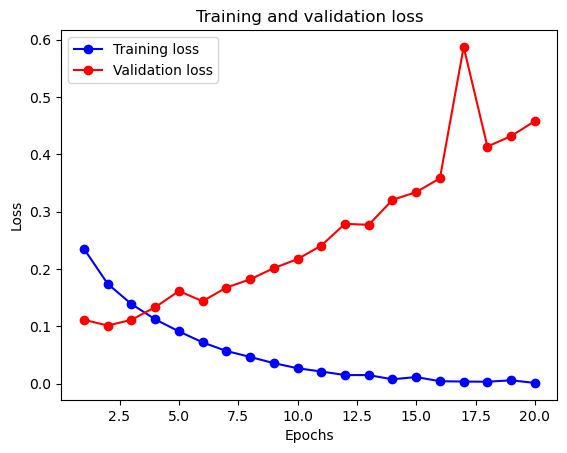

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b-o', label='Training loss')
plt.plot(epochs, val_loss_values, 'r-o', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

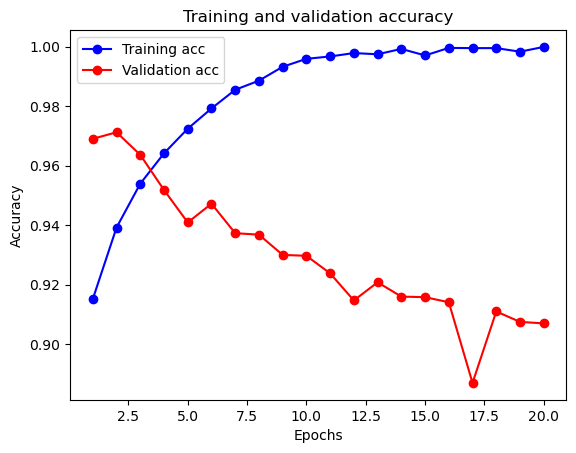

In [16]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.plot(epochs, acc, 'b-o', label='Training acc')
plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
results = model.evaluate(x_test, y_test)
print(results)

782/782 [==============================] - 1s 2ms/step - loss: 0.8221 - accuracy: 0.8585
[0.8220899105072021, 0.8584799766540527]


## CrossValidation

# Regularization

## Dropout

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
30/30 [==============================] - 2s 54ms/step - loss: 0.6592 - accuracy: 0.5942 - val_loss: 0.5019 - val_accuracy: 0.8426
Epoch 2/20
30/30 [==============================] - 1s 31ms/step - loss: 0.5101 - accuracy: 0.7623 - val_loss: 0.4002 - val_accuracy: 0.8556
Epoch 3/20
30/30 [==============================] - 1s 35ms/step - loss: 0.4301 - accuracy: 0.8183 - val_loss: 0.3295 - val_accuracy: 0.8834
Epoch 4/20
30/30 [==============================] - 1s 31ms/step - loss: 0.3654 - accuracy: 0.8571 - val_loss: 0.2944 - val_accuracy: 0.8850
Epoch 5/20
30/30 [==============================] - 1s 31ms/step - loss: 0.3111 - accuracy: 0.8828 - val_loss: 0.2931 - val_accuracy: 0.8806
Epoch 6/20
30/30 [==============================] - 1s 32ms/step - loss: 0.2724 - accuracy: 0.9017 - val_loss: 0.2820 - val_accuracy: 0.8856
Epoch 7/20
30/30 [==============================] - 1s 32ms/step - loss: 0.2383 - accuracy: 0.9205 - val_loss: 0.2780 - val_accuracy: 0.8879
Epoch 8/20
30

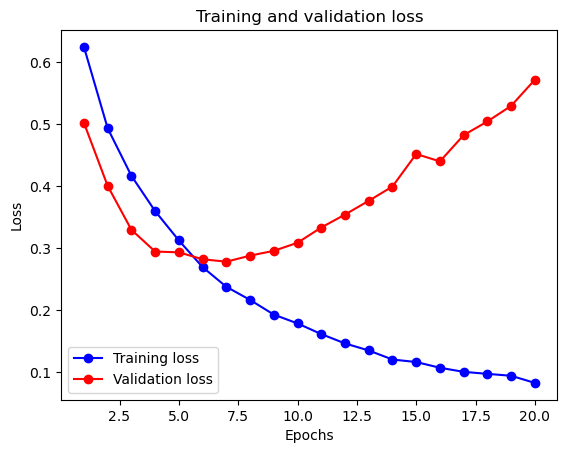

In [ ]:
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val))

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b-o', label='Training loss')
plt.plot(epochs, val_loss_values, 'r-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Batch normalization

In [ ]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                160016    
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,433
Trainable params: 160,369
Non-trainable params: 64
_________________________________________________________________


Epoch 1/20
30/30 [==============================] - 3s 60ms/step - loss: 0.5635 - accuracy: 0.7178 - val_loss: 0.5831 - val_accuracy: 0.8553
Epoch 2/20
30/30 [==============================] - 1s 36ms/step - loss: 0.2043 - accuracy: 0.9329 - val_loss: 0.5120 - val_accuracy: 0.8630
Epoch 3/20
30/30 [==============================] - 1s 27ms/step - loss: 0.1109 - accuracy: 0.9726 - val_loss: 0.4526 - val_accuracy: 0.8629
Epoch 4/20
30/30 [==============================] - 1s 26ms/step - loss: 0.0655 - accuracy: 0.9878 - val_loss: 0.4102 - val_accuracy: 0.8589
Epoch 5/20
30/30 [==============================] - 1s 33ms/step - loss: 0.0339 - accuracy: 0.9965 - val_loss: 0.3718 - val_accuracy: 0.8565
Epoch 6/20
30/30 [==============================] - 1s 33ms/step - loss: 0.0179 - accuracy: 0.9991 - val_loss: 0.3694 - val_accuracy: 0.8467
Epoch 7/20
30/30 [==============================] - 1s 31ms/step - loss: 0.0099 - accuracy: 0.9997 - val_loss: 0.3351 - val_accuracy: 0.8553
Epoch 8/20
30

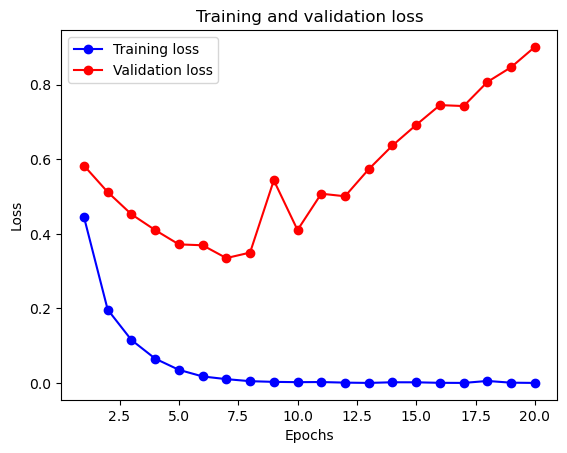

In [ ]:
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val))

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b-o', label='Training loss')
plt.plot(epochs, val_loss_values, 'r-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Weight Regularization

Epoch 1/20
30/30 [==============================] - 2s 42ms/step - loss: 0.6452 - accuracy: 0.6723 - val_loss: 0.4380 - val_accuracy: 0.8687
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.3800 - accuracy: 0.8960 - val_loss: 0.3705 - val_accuracy: 0.8772
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2994 - accuracy: 0.9182 - val_loss: 0.3382 - val_accuracy: 0.8887
Epoch 4/20
30/30 [==============================] - 0s 17ms/step - loss: 0.2530 - accuracy: 0.9369 - val_loss: 0.3334 - val_accuracy: 0.8894
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2323 - accuracy: 0.9425 - val_loss: 0.3346 - val_accuracy: 0.8881
Epoch 6/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2138 - accuracy: 0.9523 - val_loss: 0.3459 - val_accuracy: 0.8825
Epoch 7/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1956 - accuracy: 0.9586 - val_loss: 0.4144 - val_accuracy: 0.8625
Epoch 8/20
30

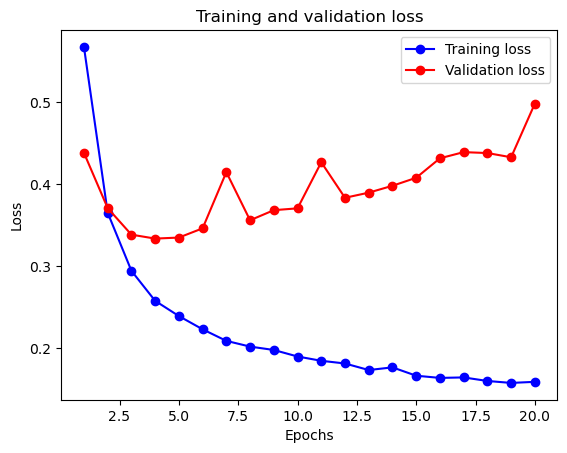

In [ ]:
from tensorflow.keras import regularizers

model = models.Sequential(name='imdb')
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(1, name='output',  activation='sigmoid'))

model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_data = (x_val, y_val))

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b-o', label='Training loss')
plt.plot(epochs, val_loss_values, 'r-o', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras import regularizers

regularizers.l1(0.001)
regularizers.l1_l2(l1=0.001, l2=0.001)

# CIFAR-10